<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/02123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

这一节用 MXNet

## 9.4 锚框

In [0]:
%matplotlib inline 
from PIL import Image 
import numpy as np 
import math 
import torch 
import d2l 

### 9.4.1 生成多个锚框

In [2]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15713 (delta 0), reused 1 (delta 0), pack-reused 15708
Receiving objects: 100% (15713/15713), 159.57 MiB | 34.73 MiB/s, done.
Resolving deltas: 100% (11136/11136), done.


In [3]:
d2l.set_figsize()
img = Image.open('d2l-zh/img/catdog.jpg')
w, h = img.size 
print('w = %d, h = %d' % (w, h))

w = 728, h = 561


In [4]:
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    pairs = []
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])
    pairs = np.array(pairs) 
    ss1 = pairs[:, 0] * pairs[:, 1]
    ss2 = pairs[:, 0] / pairs[:, 1]
    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2 

    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w 
    shifts_y = np.arange(0, h) / h 
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)

X = torch.Tensor(1, 3, h, w)
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

torch.Size([1, 2042040, 4])

In [5]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]

tensor([-0.0316,  0.0706,  0.7184,  0.8206])

In [0]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values 
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj 

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], 
                 va='center', ha='center', fontsize=6, color=text_color, 
                 bbox=dict(facecolor=color, lw=0))

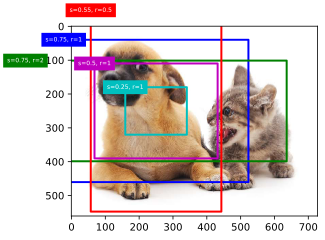

In [7]:
d2l.set_figsize(figsize=(5, 3.5))
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, 
      ['s=0.75, r=1', 's=0.75, r=2', 's=0.55, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])

### 9.4.2 交并比

In [0]:
def compute_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]

In [0]:
def compute_jaccard(set_1, set_2):
    intersection = compute_intersection(set_1, set_2)
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection 
    return intersection / union

### 9.4.3 标注训练集的锚框

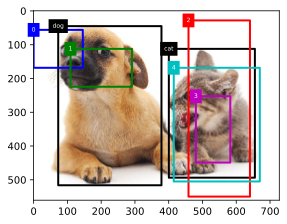

In [10]:
bbox_scale = torch.tensor((w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92], 
                [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4], 
            [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8], 
            [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [0]:
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy()
    assigned_idx = np.ones(na) * (-1)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j 
        jaccard_cp[i, :] = float('-inf')

    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j 
    return torch.tensor(assigned_idx, dtype=torch.long)

In [0]:
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2, 
              xy[:, 2:] - xy[:, :2]], 1)

In [0]:
def MultiBoxTarget(anchor, label):
    assert len(anchor.shape) == 3 and len(label.shape) == 3 
    bn = label.shape[0]

    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        an = anc.shape[0]
        assigned_idx = assign_anchor(lab[:, 1:], anc)
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4)
        cls_labels = torch.zeros(an, dtype=torch.long)
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32)
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0:
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 
                assigned_bb[i, :] = lab[bb_idx, 1:]

        center_anc = xy_to_cxcy(anc)
        center_assigned_bb = xy_to_cxcy(assigned_bb)
        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim=1) * bbox_mask 
        return offset.view(-1), bbox_mask.view(-1), cls_labels 

    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    return [bbox_offset, bbox_mask, cls_labels]

In [0]:
labels = MultiBoxTarget(anchors.unsqueeze(dim=0), 
             ground_truth.unsqueeze(dim=0))

In [30]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [31]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [32]:
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

### 9.4.4 输出预测边界框

In [0]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95], 
             [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0.0] * (4 * len(anchors)))
cls_probs = torch.tensor([[0., 0., 0., 0.], 
              [0.9, 0.8, 0.7, 0.1], 
              [0.1, 0.2, 0.3, 0.9]])

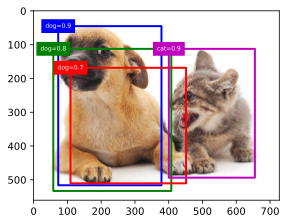

In [34]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, 
      ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [0]:
from collections import namedtuple
Pred_BB_Info = namedtuple('Pred_BB_Info', ['index', 'class_id', 'confidence', 'xyxy'])

def non_max_supression(bb_info_list, nms_threshold=0.5):
    output = []
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)
    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)
        if len(sorted_bb_info_list) == 0:
            break 
        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                    torch.tensor(bb_xyxy))[0]
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output 

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold=0.5):
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3 
    bn = cls_prob.shape[0]

    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold=0.5):
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy()
        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        pred_bb_info = [Pred_BB_Info(
            index = i, 
            class_id = class_id[i] - 1, 
            confidence = confidence[i], 
            xyxy = [*anc[i]]
        ) 
        for i in range(pred_bb_num)]
        obj_bb_idx = [bb.index for bb in non_max_supression(pred_bb_info, nms_threshold)]
        
        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0), 
                bb.confidence, 
                *bb.xyxy
            ])
        return torch.tensor(output)

    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
    return torch.stack(batch_output)

In [40]:
output = MultiBoxDetection(
    cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0), 
    anchors.unsqueeze(dim=0), nms_threshold=0.5
)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800]]])

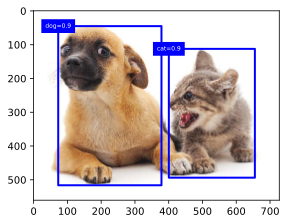

In [41]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1:
        continue 
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)